In [17]:
# import cv2
import math
import numpy as np
from PIL import Image
import scipy
import scipy.misc
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from artboard import Artboard, Yarn
n=120
d=304.8
dim = 500
board = Artboard(d, n)

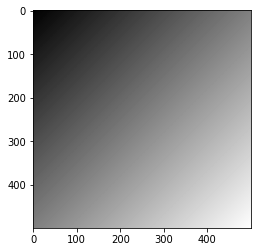

In [18]:
#random 500x500 image
img = 255 - np.array(Image.open('img/rect815.png').convert('L'))
plt.imshow(img, cmap='binary')
# img = img**2

In [19]:
img_test = np.zeros(img.shape)
pixels_arr=[]
img_data_arr=[]
curr_pixel_id = 0
pixel_id_lookup = [[-1] * dim] * dim
for y in range(0, dim):
    for x in range(0, dim):
        if (x - dim/2)**2 + (y - dim/2)**2 <= (dim/2)**2:
            pixels_arr.append([x, y])
            pixel_id_lookup[x][y] = curr_pixel_id
            img_data_arr.append(img[dim - y - 1][x])
            curr_pixel_id += 1
pixels = np.array(pixels_arr)
img_data = np.array(img_data_arr)
(pixels, img_data)

(array([[250,   0],
        [228,   1],
        [229,   1],
        ...,
        [270, 499],
        [271, 499],
        [272, 499]]), array([ 64,  70,  69, ..., 186, 186, 185], dtype=uint8))

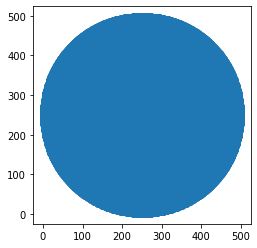

In [20]:
plt.axes().set_aspect('equal')
plt.scatter(pixels[:,0],pixels[:,1])

In [21]:
strings_arr=[]
string_id_to_pins=[]
def get_point(pin):
    angle = board._pin_angle_(pin)
    radius = (dim - 2) / 2.0
    return [radius * math.cos(angle), radius * math.sin(angle)]
for i in range(0,n):
    for j in range(i+1,n):
        string_id_to_pins.append((i,j))
        strings_arr.append([get_point(i), get_point(j)])
        # if len(strings_arr) == 635:
        #     print(i, j, strings_arr[634])
strings = np.array(strings_arr) + np.array([dim/2.0, dim/2.0])
strings

array([[[250.        , 499.        ],
        [236.9683469 , 498.65875415]],

       [[250.        , 499.        ],
        [223.97241265, 497.63595195]],

       [[250.        , 499.        ],
        [211.0478182 , 495.93439681]],

       ...,

       [[288.9521818 , 495.93439681],
        [276.02758735, 497.63595195]],

       [[288.9521818 , 495.93439681],
        [263.0316531 , 498.65875415]],

       [[276.02758735, 497.63595195],
        [263.0316531 , 498.65875415]]])

Naive attempt at measuring effect of a string on a pixel.



In [22]:

coo_matrix_values = []
coo_matrix_rows = []
coo_matrix_cols = []
max_score = 0.4
def putpixel(string_id, xy, alpha=1):
    # coo_matrix_values.append(val)
    # coo_matrix_rows.append(pixel_id)
    # coo_matrix_cols.append(string_id)
    coo_matrix_values.append(max_score*alpha)
    coo_matrix_rows.append(pixel_id_lookup[xy[0]][xy[1]])
    coo_matrix_cols.append(string_id)
def _fpart(x):
    return x - int(x)
 
def _rfpart(x):
    return 1 - _fpart(x)
def draw_line(string_id, p1, p2):
    """Draws an anti-aliased line in img from p1 to p2 with the given color."""
    x1, y1 = p1
    x2, y2 = p2
    # print(y2,y1)
    dx, dy = x2-x1, y2-y1
    steep = abs(dx) < abs(dy)
    p = lambda px, py: ((px,py), (py,px))[steep]
 
    if steep:
        x1, y1, x2, y2, dx, dy = y1, x1, y2, x2, dy, dx
    if x2 < x1:
        x1, x2, y1, y2 = x2, x1, y2, y1
 
    grad = dy/dx
    # print(p1, p2)
    intery = y1 + _rfpart(x1) * grad
    def draw_endpoint(pt):
        x, y = pt
        xend = round(x)
        yend = y + grad * (xend - x)
        # print(grad)
        xgap = _rfpart(x + 0.5)
        # print(string_id)
        px, py = int(xend), int(yend)
        putpixel(string_id, p(px, py), _rfpart(yend) * xgap)
        # putpixel(string_id, p(px, py+1), _fpart(yend) * xgap)
        return px
 
    xstart = draw_endpoint(p(*p1)) + 1
    xend = draw_endpoint(p(*p2))
    # print((xstart, xend))
    for xt in range(xstart, xend):
        yt = int(intery)
        putpixel(string_id, p(xt, yt), _rfpart(intery))
        putpixel(string_id, p(xt, yt+1), _fpart(intery))
        intery += grad

for string_id_iterator in range(0,len(strings)):
    swap = strings[string_id_iterator][0][0] > strings[string_id_iterator][1][0]
    right = strings[string_id_iterator][1] if not swap else strings[string_id_iterator][0]
    left = strings[string_id_iterator][0] if not swap else strings[string_id_iterator][1]
    # print(strings[634])
    draw_line(string_id_iterator, left, right)
    # if left[0] < 497 and left[0] > 3 and left[1] < 497 and left[1] > 3 and right[0] < 497 and right[0] > 3 and right[1] < 497 and right[1] > 3:
    #     draw_line(string_id_iterator, left + np.array([2, 2]), right + np.array([2, 2]))
    #     draw_line(string_id_iterator, left + np.array([1, 1]), right + np.array([1, 1]))
    #     draw_line(string_id_iterator, left + np.array([-1, -1]), right + np.array([-1, -1]))
    #     draw_line(string_id_iterator, left + np.array([-2, -2]), right + np.array([-2, -2]))
    # print(strings[15])
    # print(string_id_iterator, "/", len(strings))
matrix = scipy.sparse.coo_matrix((coo_matrix_values, (coo_matrix_rows, coo_matrix_cols))).tocsr()
matrix

/home/david/developer/stringart/venv/lib64/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


<196319x7140 sparse matrix of type '<class 'numpy.float64'>'
	with 953705 stored elements in Compressed Sparse Row format>

In [23]:
solution = scipy.sparse.linalg.lsqr(matrix, img_data)[0]
np.amax(solution)

10.11367965995708

In [24]:
solution

array([5.49999327, 2.73706158, 2.61227967, ..., 0.28356468, 0.29844888,
       0.10236133])

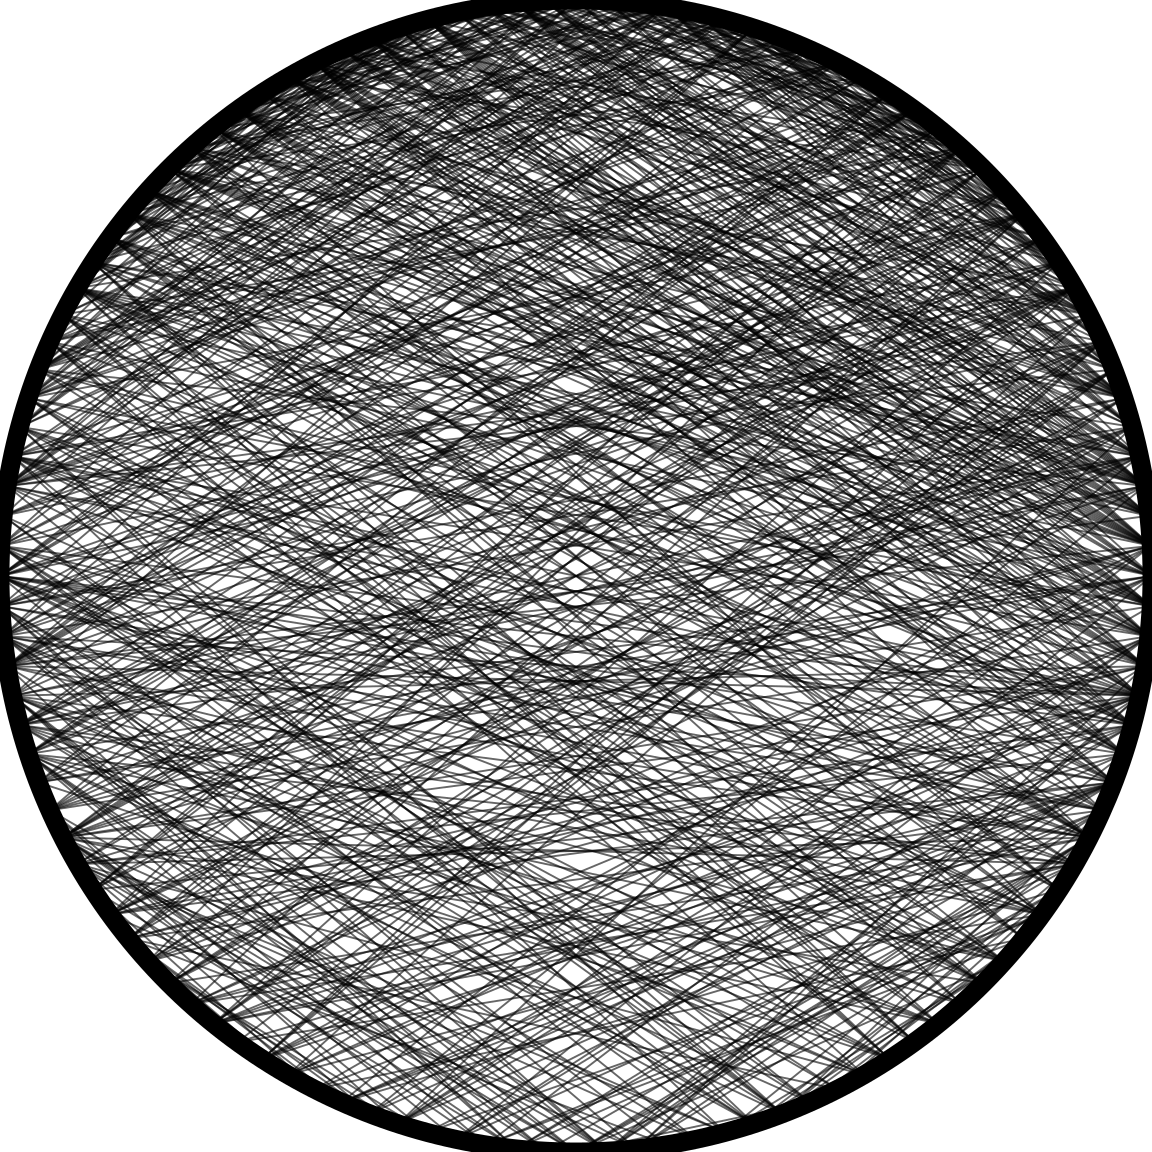

In [27]:
threshold = 0.7
board.reset()
list(map(lambda x: board.add_string(string_id_to_pins[x][0], string_id_to_pins[x][1]), np.where(solution > threshold)[0]))
board.render(background="#FFFFFF").rasterize()

